In [2]:
# 第一個代碼塊：下載並解壓數據集
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git
!mv Face-Mask-Detection/dataset ./dataset

# 安裝所需的庫
!pip install tensorflow pillow requests

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 4590, done.
remote: Total 4590 (delta 0), reused 0 (delta 0), pack-reused 4590 (from 1)
Receiving objects: 100% (4590/4590), 186.72 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Updating files: 100% (4155/4155), done.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt

Found 3274 images belonging to 2 classes.
Found 818 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 62/103 ━━━━━━━━━━━━━━━━━━━━ 23s 568ms/step - accuracy: 0.6717 - loss: 2.1706

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 92s 714ms/step - accuracy: 0.7368 - loss: 1.6638 - val_accuracy: 0.9597 - val_loss: 0.1164
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 113s 563ms/step - accuracy: 0.9421 - loss: 0.1371 - val_accuracy: 0.9731 - val_loss: 0.0856
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 58s 543ms/step - accuracy: 0.9591 - loss: 0.1240 - val_accuracy: 0.9719 - val_loss: 0.0849
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 59s 537ms/step - accuracy: 0.9377 - loss: 0.1443 - val_accuracy: 0.9817 - val_loss: 0.0600
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 530ms/step - accuracy: 0.9602 - loss: 0.1097 - val_accuracy: 0.9707 - val_loss: 0.0882
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 59s 543ms/step - accuracy: 0.9519 - loss: 0.1275 - val_accuracy: 0.9853 - val_loss: 0.0491
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 527ms/step - accuracy: 0.9523 - loss: 0.1211 - val_accuracy: 0.9682 - val_loss: 0.0933
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 83s 527ms/step - accuracy: 0.9563 - loss: 0.1047 - va

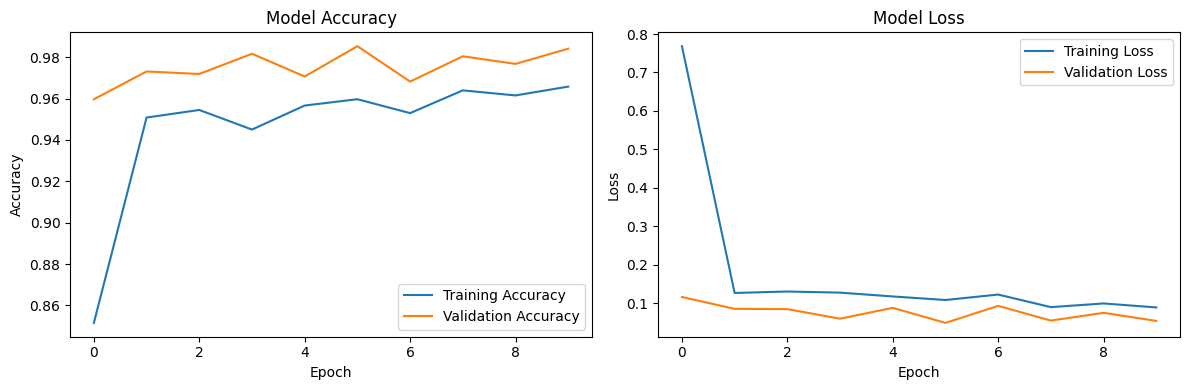

In [4]:
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        'dataset',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        'dataset',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 第四個代碼塊：訓練模型
def train_model(model, train_generator, validation_generator):
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator
    )

    # 繪製訓練過程圖表
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return history

# 第五個代碼塊：圖片預測功能
def preprocess_image_from_url(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    img = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

# 第六個代碼塊：主程序執行
# 創建數據生成器
train_generator, validation_generator = create_data_generators()

# 構建並訓練模型
model = build_model()
history = train_model(model, train_generator, validation_generator)

# 保存模型
model.save('mask_detection_model.h5')

請輸入圖片URL: https://na.cx/i/eqzQJYw.jpg


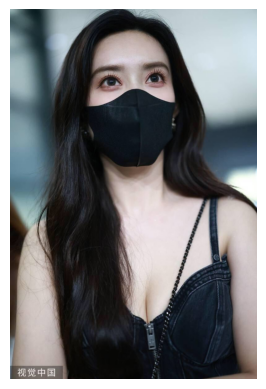

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
預測結果: with_mask
信心度: 99.29%


('with_mask', 99.28569793701172)

In [6]:
# 修改預測函數
def test_image(image_url, model, class_indices):
    # 顯示原始圖片
    response = requests.get(image_url)
    img = Image.open(io.BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # 預測
    processed_image = preprocess_image_from_url(image_url)
    predictions = model.predict(processed_image)

    # 反轉類別索引字典
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    print(f"預測結果: {predicted_class}")
    print(f"信心度: {confidence:.2f}%")

    return predicted_class, confidence

image_url = input("請輸入圖片URL: ")
test_image(image_url, model, train_generator.class_indices)